In [85]:
# importing all the required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [10, 5]

import geopandas
from shapely.geometry import Point

In [2]:
raw_train = '../data/raw/train.csv'
raw_test = '../data/raw/test.csv'

In [4]:
nyc_train = pd.read_csv(raw_train, parse_dates=['pickup_datetime', 'dropoff_datetime']) 
nyc_test = pd.read_csv(raw_test, parse_dates=['pickup_datetime']) 

In [5]:
nyc_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
nyc_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [8]:
nyc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [9]:
nyc_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [10]:
# Creating the trip duration columns in minutes and hours for better interpretation
nyc_train['trip_duration_hours'] = nyc_train.trip_duration.apply(lambda x: x/60/60)
nyc_train['trip_duration_minutes'] = nyc_train.trip_duration.apply(lambda x: x/60)

In [11]:
nyc_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hours,trip_duration_minutes
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,7.583333
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,11.050000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,35.400000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,7.150000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,7.250000


In [12]:
nyc_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06
trip_duration_hours,1458644.0,0.266526,1.454842,0.000278,0.110278,0.183889,0.298611,9.795228e+02
trip_duration_minutes,1458644.0,15.991538,87.290529,0.016667,6.616667,11.033333,17.916667,5.877137e+04


* From initial EDA it can be seen that the maximum trip duration is around 979 hours which looks like an outlier. 
* The median trip duration is around 11 minutes and 75% of the trips are under 18 minutes.

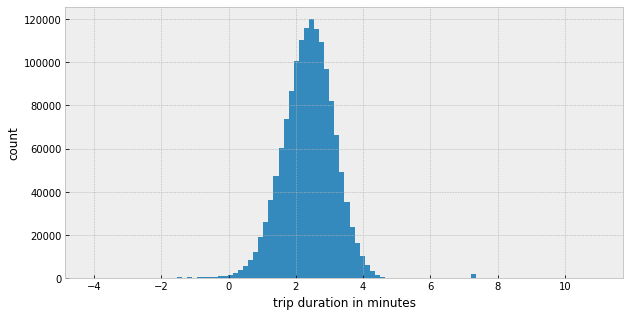

In [28]:
_ = plt.hist(np.log(nyc_train.trip_duration_minutes), bins = 100)
_ = plt.xlabel('trip duration in minutes')
_ = plt.ylabel('count')
# _ = plt.xscale('log')

In [33]:
# To better visualize let's creat a function to draw the cumulative distirbution function 
def ecdf(input, xlabel):
    """ Plot the Cumulative distribution of the input variable and label the x-axis as 'xlabel' """
    x = np.sort(input)
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker = '.', linestyle = 'none')
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('ECDF')
    plt.margins(0.02)
    plt.xscale('log')

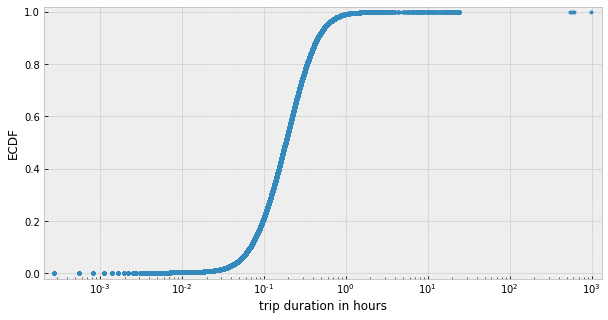

In [34]:
ecdf(nyc_train.trip_duration_hours, "trip duration in hours")

In [35]:
# let's check and remove points above 1 day i.e. 24 hours
nyc_train[nyc_train['trip_duration_hours'] > 24]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hours,trip_duration_minutes
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,538.815556,32328.933333
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,569.327222,34159.633333
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,618.781111,37126.866667
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,979.522778,58771.366667


* Data in the other columns looks normal and it represents only 4 data points out of more than a million trips so we might as well delete these trips. 

In [37]:
# Deleting the trips with duration>24 hours
nyc_train.drop(nyc_train[nyc_train.trip_duration_hours > 24].index, inplace=True)

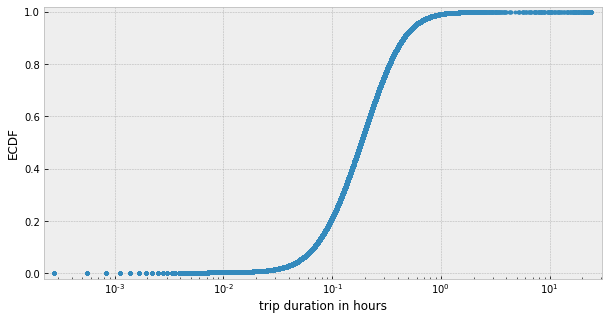

In [38]:
ecdf(nyc_train['trip_duration_hours'], "trip duration in hours")

In [39]:
# Checking if any of the values in any of the rows or the columns is null
nyc_train.isnull().any(axis = 1).sum()

0

No missing values. But there still can outliers, for example pickup and drop off locations not located in NYC or not located on land, etc. We'll check that later while doing some geospatial analysis.

In [41]:
nyc_train.pickup_datetime.dt.year.unique()

array([2016], dtype=int64)

In [42]:
# Creating temporal variables
nyc_train['pickup_date'] = nyc_train.pickup_datetime.dt.date
nyc_train['pickup_month'] = nyc_train.pickup_datetime.dt.month
nyc_train['pickup_day'] = nyc_train.pickup_datetime.dt.day
nyc_train['pickup_hour'] = nyc_train.pickup_datetime.dt.hour
nyc_train['pickup_weekday'] = nyc_train.pickup_datetime.dt.weekday_name

#Adding holidays column to indicate whether a day was a holiday as per the US calendar or not
cal = calendar()
holidays = cal.holidays(start = nyc_train.pickup_datetime.dt.date.min(), end = nyc_train.pickup_datetime.dt.date.max())
nyc_train['holiday'] = 1*nyc_train.pickup_datetime.dt.date.isin(holidays)

In [43]:
nyc_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hours,trip_duration_minutes,pickup_date,pickup_month,pickup_day,pickup_hour,pickup_weekday,holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,7.583333,2016-03-14,3,14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,11.050000,2016-06-12,6,12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,35.400000,2016-01-19,1,19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,7.150000,2016-04-06,4,6,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,7.250000,2016-03-26,3,26,13,Saturday,0


In [78]:
nyc_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458640.0,1.534952,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,1458640.0,1.664531,1.314244,0.000000,1.000000,1.000000,2.000000,9.000000
pickup_longitude,1458640.0,-73.973487,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-61.335529
pickup_latitude,1458640.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,51.881084
dropoff_longitude,1458640.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-61.335529
dropoff_latitude,1458640.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,43.921028
trip_duration,1458640.0,952.815252,3171.322283,1.000000,397.000000,662.000000,1075.000000,86392.000000
trip_duration_hours,1458640.0,0.264671,0.880923,0.000278,0.110278,0.183889,0.298611,23.997778
trip_duration_minutes,1458640.0,15.880254,52.855371,0.016667,6.616667,11.033333,17.916667,1439.866667
pickup_month,1458640.0,3.516823,1.681036,1.000000,2.000000,4.000000,5.000000,6.000000


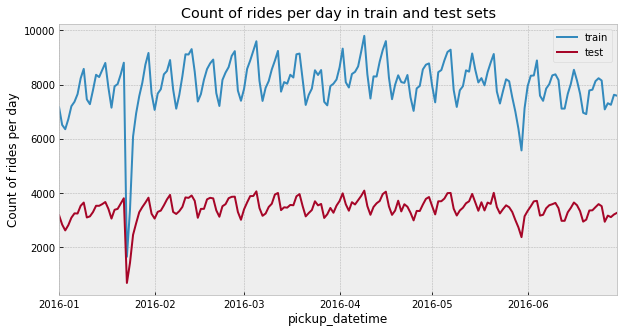

In [54]:
# Checking number of trips by day
_ = nyc_train.groupby('pickup_date')['id'].count().plot()
_ = plt.title('Count of rides per day in train and test sets')
_ = nyc_test.groupby(nyc_test.pickup_datetime.dt.date)['id'].count().plot()
_ = plt.ylabel('Count of rides per day')
_ = plt.legend(['train', 'test'])

We see that there is overlap between train and test sets. 

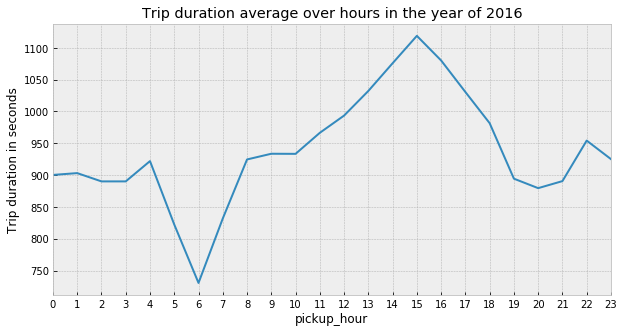

In [56]:
#Plotting average trip duration for each hour over the entire year
nyc_train.groupby('pickup_hour')['trip_duration'].mean().plot()
_ = plt.ylabel('Trip duration in seconds')
_ = plt.xticks(nyc_train['pickup_hour'].unique())
_ = plt.title('Trip duration average over hours in the year of 2016')

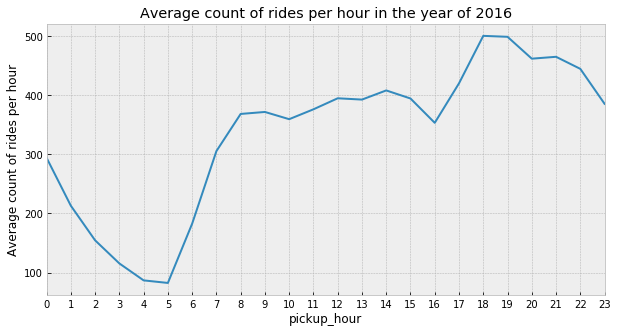

In [73]:
# This time plotting the above graph but with average number of rides per hour
_ = nyc_train.groupby(['pickup_date',  'pickup_hour']).count().groupby('pickup_hour').mean()['id'].plot()
_ = plt.ylabel('Average count of rides per hour')
_ = plt.xticks(nyc_train['pickup_hour'].unique())
_ = plt.title('Average count of rides per hour in the year of 2016')

In [81]:
# Mapping the trip duration in seconds over each hour of each weekday

#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average
#trip duration in minutes for that particular hour of the weekday
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cat_dtype = pd.api.types.CategoricalDtype(categories = cats, ordered=True)

nyc_train['pickup_weekday'] = nyc_train['pickup_weekday'].astype(cat_dtype)

hour_weekday = nyc_train.pivot_table(values = 'trip_duration_minutes', index = 'pickup_hour', 
                                     columns = 'pickup_weekday', aggfunc = 'mean')

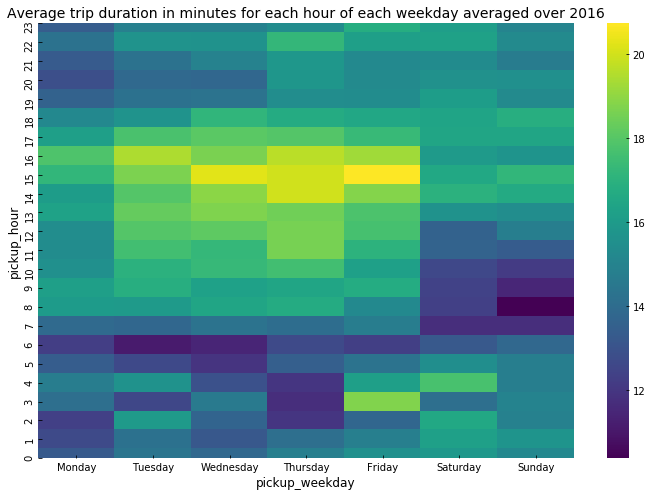

In [82]:
#plotting a heatmap with a colorbar; the colorbar shows the trip duration in minutes

_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
_ = ax.set_title("Average trip duration in minutes for each hour of each weekday averaged over 2016", fontsize = 14)

In [100]:
# Getting to know GEOJSON file:
country = geopandas.read_file('../data/external/usgeojson/gz_2010_us_040_00_5m.json')

In [101]:
country.head(3)

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."


In [103]:
NY_state = country[country['NAME']=="New York"]

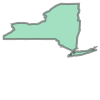

In [110]:
NY_state['geometry'].tolist()[0]

In [120]:
type(NY_state.geometry)

geopandas.geoseries.GeoSeries

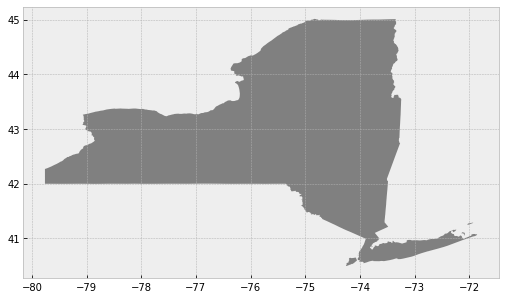

In [147]:
_ = NY_state.plot(figsize=(10,5), color='grey', )

(-74.03, -73.75)

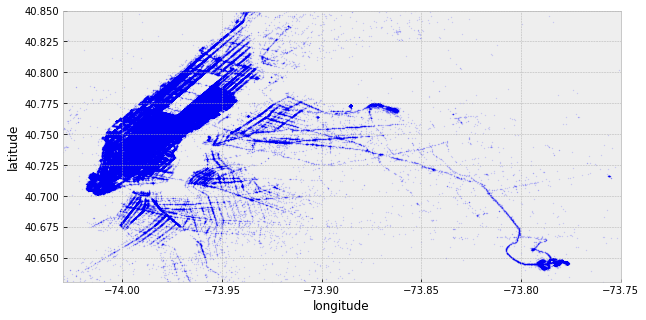

In [151]:
nyc_long_limits = (-74.03, -73.75)
nyc_lat_limits = (40.63, 40.85)
fig, ax = plt.subplots(1)
ax.scatter(nyc_train['pickup_longitude'].values, nyc_train['pickup_latitude'].values,
              color='blue', s=1, label='train', alpha=0.1)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

plt.ylim(nyc_lat_limits)
plt.xlim(nyc_long_limits)


Things to check:
* Whether train and test datasets are unique and they don't have any overalapping unique id trips. 
* Check the boundary of NYC and see if all pickup and dropoff lat/lon are within that boundary. if not, then filter the outliers out. 
* Do geospatial analysis to check how the above plots differ from area to area. 
* See by clustering how many number of similar clusters are formed. 